In [ ]:
"""
    @Author: Vítor Ferrante Cavarzare
    @Data: 23/11/2022
    @Project: Teste Jr Atmo
""

# 0. Bibliotecas

In [2]:
# Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Parâmetros
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

# Atividades

## 1) Cálculo de ENA

De forma a entender o que está acontecendo no sistema elétrico brasileiro é necessário ter conhecimento da situação hidrológica em cada usina hidroelétrica. Uma visualização bastante comum é agregar os pontos de medição em macro regiões denominadas subsistemas (SE, S, NE e N).
Para agregar em subsistemas é necessário, primeiro, converter a vazão natural (val_vaz_natr) para variável Energia Natural Afluente - ENA, dada pela equação abaixo.

ENA  = val_vaz_natr * val_produt

Leia os dados de vazão e o cadastro dos postos, realize os cálculos necessários para determinar a ENA dos postos, conforme a equação mencionada, e exponha os resultados da ENA agregada em subsistemas, tanto em média diária quanto em média mensal diária.

**obs1**: Os dados para essa pergunta estão nos arquivos tbl_postos.csv e tbl_vazao.csv.  
**obs2**: Somente os postos de medicão com a variável bin_ena = 1 são considerados no cálculo oficial de ENA. Leve isso em consideração.
 

### Resolução

1) Importação dos dataset

In [172]:
df_postos = pd.read_csv('../data/tbl_postos.csv')
df_vazao = pd.read_csv('../data/tbl_vazao.csv')

2) Join entre tabelas (semelhante ao left join no SQL)

In [173]:
df = pd.merge(df_postos,df_vazao,on='num_posto',how='left')

3) Cálculo da ENA (Enegia Natural Afluente)

In [174]:
df['ENA'] = df['val_produt'] * df['val_vaz_natr']

4) Filtro de bin_ena = 1 (comando query utilizado semelhante ao where do SQL)

In [175]:
df_filtrado = df.query('bin_ena == 1').copy()

5) Média diária por subsistema

Com os dados conseguimos observar que a região N é a que possui maior Energia Natural Afluente.  
Pelos dados vemos que esse indicador, ENA, é 2.32x maior que a segunda maior região, NE.

In [176]:
df_filtrado.groupby('nom_ssis')['ENA'].mean()

nom_ssis
N     1075.797259
NE     462.188106
S      226.443710
SE     338.482007
Name: ENA, dtype: float64

6) Média diária mensal por subsistema

É observado que os meses de maior ENA são os das estações de verão e outono, onde temos a maior incidência de chuvas. Conforme [Artigo Figura 3](https://www.researchgate.net/figure/Figura-3-Padrao-sazonal-da-chuva-A-linha-azul-representa-a-media-das-chuvas-entre-2001_fig3_326088461)

Text(0.5, 1.0, 'ENA mensal média por subsistema')

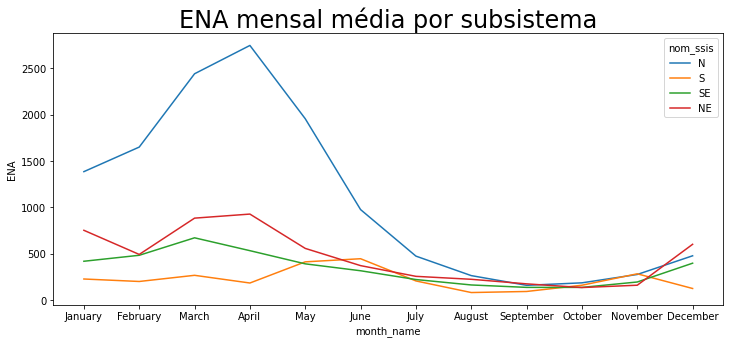

In [184]:
df_filtrado['month'] = pd.to_datetime(df_filtrado['dat_medicao']).dt.month
df_filtrado['month_name'] = pd.to_datetime(df_filtrado['dat_medicao']).dt.month_name()
df_plot = df_filtrado.groupby(['nom_ssis','month','month_name'])['ENA'].mean().round(2).reset_index().sort_values('month')
fig,ax=plt.subplots(1,figsize=(12,5))
sns.lineplot(x='month_name',y='ENA',hue='nom_ssis',data=df_plot,sort=False)
plt.title('ENA mensal média por subsistema',size=24)

## 2) Pokemon API

Utilize a API de referência para buscar informações sobre os pokemons da primeira geração (150) e monte um dataframe contendo seus nomes, suas habilidades e um dos locais onde ele pode ser encontrado.
Descreva qual seria a forma mais interessante para requisitar esses dados da API caso o número de pokemons fosse na verdade 1.500.000. Caso deseje, desenvolva o código já com essa mentalidade.
Utilize https://pokeapi.co/docs/v2 como referência e documentação

### Resolução

Estudando a api, precisamos iniciar com a coleta dos nomes dos pokemons pela geração, pois nome é um dos endpoints de outras chamadas da api. Com isso, foi feito um loop em que conseguimos registrar em uma lista (**lista_nomes_pokemons**) seus devidos nomes.

In [186]:
# Importando biblioteca requests para requisição get em python
import requests 
url_api = 'https://pokeapi.co/api/v2/generation/generation-i' 
df = requests.get(url_api).json()
lista_nomes_pokemons = []
for i in df['pokemon_species']:
    lista_nomes_pokemons.append(i['name'])

Com os nomes registrados, agora precisamos requisitar a api do pokemon para coletar suas habilidades, como também requistar a api de localidades. Assim, foi feito um loop para pegar cada nome registrado na lista (**lista_nomes_pokemons**) e então adicionado na (**lista_pokemon**), para em seguida ser transformada em um pandas dataframe.

In [187]:
def get_pokemon(nome):
    url_api_pokemon = f'https://pokeapi.co/api/v2/pokemon/{nome}/' 
    return requests.get(url_api_pokemon).json()

def get_local(nome):
    url_api = f'https://pokeapi.co/api/v2/pokemon/{nome}/encounters' 
    return requests.get(url_api).json()

lista_pokemon = []
for j in lista_nomes_pokemons:
    df_pokemon = get_pokemon(j)
    lista_habilidades = []
    for k in df_pokemon['abilities']:
        lista_habilidades.append(k['ability']['name'])
    try:    
        df_local = get_local(j)
        regiao = pd.DataFrame(df_local)['location_area'].to_dict()[0]['name']
        lista_pokemon.append([j,lista_habilidades,regiao])
    except:
        lista_pokemon.append([j,lista_habilidades,'Local Não Encontrado'])

Colocando a lista em formato de dataframe temos então três colunas, sendo o Nome, Habilidade e Região do pokemon. 
O tempo para o loop dessa consulta foi de 1min e 6s, o que pensando para uma volumetria de 1,5 milhões de pokemons ficaria inviável. Precisaria de mais algum tempo para pensar em uma solução otimizada. 
O comando try: except: foi utilizado pois para alguns pokemons não foram encontrados locais, então faz a subscrição para o status de "Local Não Encontrado"

In [188]:
pokemon = pd.DataFrame(lista_pokemon).rename(columns={
    0:'Nome',
    1:'Habilidades',
    2:'Região'
})
pokemon.head()

,Nome,Habilidades,Região
0,bulbasaur,"[overgrow, chlorophyll]",cerulean-city-area
1,charmander,"[blaze, solar-power]",pallet-town-area
2,squirtle,"[torrent, rain-dish]",vermilion-city-area
3,caterpie,"[shield-dust, run-away]",eterna-forest-area
4,weedle,"[shield-dust, run-away]",eterna-forest-area


In [189]:
pokemon.shape

(151, 3)

## 3) Ingestão de dados

Contexto
No dia a dia é comum precisarmos interagir com arquivos que nem sempre estão em bons formatos para guardar informações. Muitas vezes é necessário arrumar os dados para guardá-los de forma mais fácil.  

Desafio:
Faça um programa que leia o arquivo "ACOMPH_12.05.2020.xls" e construa um dataframe contendo as seguintes informações de todos os aproveitamentos hidroelétricos:

*   Nome do posto  
*   Código do posto  
*   Data da medição  
*   Vazão Natural Consolidada  
*   Vazão Incremental Consolidada

De posse dos dados, descreva como você modelaria um banco de dados para guardar esse tipo de informação. Qual arquitetura seria mais interessante, como organizaria as tabelas e o relacionamento entre os dados, caso seja necessário?


### Resolução

Para tratar arquivos no python no formato do excel temos algumas bibliotecas já prontas. O próprio pandas pode ser utilizado na leitura, mas costuma ser mais utilizado apenas quando o formato da planilha eme excel seja simples de utilizar. 

Nesse caso, como tem várias abas e células específicas iremos utilizar uma biblioteca mais específica. 
Temos então a **xlrd** que trabalha com **.xls** e a **openpyxl** com **.xlsx.** 

Como a localização das informações nas células se repetem, podemos criar um código que siga esse padrão independente da aba do excel ou do posto a ser coletado.

Outro ponto é que temos informações de diferentes formatos que podem ser apendadas em tabelas diferentes, como por exemplo: Dados temporais Incremental e Consolidado; dados de informação, como o nome e bacia. No caso o posto seria o id em cada uma dessas tabelas.

1) Importando a biblitoeca xlrd e lendos as abas da planilha

In [100]:
import xlrd
data_raw = xlrd.open_workbook('../data/ACOMPH_12.05.2020.xls')
data_raw.sheets()

[Sheet  0:<Grande>,
 Sheet  1:<Paranaíba>,
 Sheet  2:<Tietê>,
 Sheet  3:<Paranapanema>,
 Sheet  4:<Paraná>,
 Sheet  5:<Iguaçu>,
 Sheet  6:<Uruguai>,
 Sheet  7:<Jacui>,
 Sheet  8:<Outras Sul>,
 Sheet  9:<Paraguai>,
 Sheet 10:<Paraíba do Sul>,
 Sheet 11:<Doce>,
 Sheet 12:<Outras Sudeste>,
 Sheet 13:<São Francisco>,
 Sheet 14:<Outras Nordeste>,
 Sheet 15:<Tocantins>,
 Sheet 16:<Amazonas>,
 Sheet 17:<Araguari>]

2) Importando biblioteca datetime para transformar o formato da data do excel e loop para salvar as informações de posto, nome, vazão natural e incremental e a data de cada aferição. 

In [166]:
import datetime

lista_df = []
for i in range(len(data_raw.sheets())):
    sheet = data_raw.sheet_by_index(i)
    date = sheet.col_values(0, start_rowx=5, end_rowx=35)
    date = [datetime.datetime(*xlrd.xldate_as_tuple(i, data_raw.datemode)) for i in date]
    tamanho_colunas = sheet.ncols
    espacamento_posto = 8 
    inicio = 8
    for j in np.arange(inicio,tamanho_colunas,espacamento_posto):
        
        lista_df.append([str(data_raw.sheets()[i]).split('<')[1].replace('>',''),
                        sheet.cell_value(rowx=0,colx=j),
                        sheet.cell_value(rowx=1, colx=j-7),
                        sheet.col_values(j-1, start_rowx=5, end_rowx=35),
                        sheet.col_values(j, start_rowx=5, end_rowx=35),
                        date
                        ])

In [167]:
df = pd.DataFrame(lista_df).rename(columns={
    0:'Bacias',
    1:'Posto',
    2:'Nome_Posto',
    3:'Vazao_Natural',
    4:'Vazao_Incremental',
    5:'Data'
})
df

,Bacias,Posto,Nome_Posto,Vazao_Natural,Vazao_Incremental,Data
0,Grande,1.0,CAMARGOS,"[99.50074381224356, 103.38407019483267, 98.105...","[99.50074381224356, 103.38407019483267, 98.105...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
1,Grande,211.0,FUNIL-GRANDE,"[186.77157834439208, 185.92874774755276, 183.4...","[284.2568078023947, 287.2093494851497, 284.453...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
2,Grande,6.0,FURNAS,"[411.6799138933497, 401.4496500539919, 393.753...","[697.245041957182, 684.92057984813, 679.486814...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
3,Grande,7.0,MASCARENHAS DE MORAES,"[116.02860728217973, 114.18453739383985, 115.8...","[835.4049473306507, 810.9160600964781, 800.586...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
4,Grande,8.0,L.C.BARRETO,"[26.775832449733784, 26.350277860116886, 26.74...","[866.902501365238, 844.408930066562, 830.34363...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
...,...,...,...,...,...,...
143,Amazonas,230.0,SÃO MANOEL,"[27.268566433333326, 27.467501016666667, 27.51...","[4115.516132202944, 4147.157733989652, 4170.40...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
144,Amazonas,288.0,PIMENTAL,"[20629.93317051964, 20377.53745708504, 20212.3...","[20629.93317051964, 20377.53745708504, 20212.3...","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
145,Araguari,204.0,CACHOEIRA CALDEIRÃO,"[1525.8997584262027, 1605.4981030746499, 1635....","[1525.8997584262027, 1605.4981030746499, 1635....","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."
146,Araguari,280.0,COARACY NUNES,"[4.628614029604255, 4.8700650244933765, 4.9602...","[1522.2222534146697, 1603.7349727117726, 1637....","[2020-04-12 00:00:00, 2020-04-13 00:00:00, 202..."


Como mencionado na discussão da resolução deste exercício, para um melhor controle e otimização na rotina de storage dessas informações, seria melhor contruir tabelas apartadas no formato star schema, tendo uma tabela fato (aqui poderia ser uma tabela com o id do posto, data, vazão natural e vazão incremental) e outra tabela dimensão contendo o id, nome, vazão média mensal, bacia... 